<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/audio/Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import re

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa.display
from sklearn.preprocessing import scale
import seaborn as sns
from glob import glob

# Dati

Importiamo per prima cosa i dati da google drive. La strada deve essere quella prima di importare tutti i dati e poi di trasformarli in immagini. Una volta fatto questo le si salvano nuovamente dove sono già e poi le si importano con un image generator in modo che siano compatibili con la rete che vogliamo usare

In [181]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/prova/"

Mounted at /content/gdrive


## FUNZIONI

In [119]:
def combo(input):
    return np.concatenate((aavg(input), duration(input), zcr(input), sdev(input)))

In [120]:
def zcr(input, n_shift = 1):    
    # Remove all 0's as said before
    input = [x for x in input if x != 0]
    # It adds a number of 0 to the end equal to the n_shifts and deletes the first n_shift elements
    shifted = np.concatenate((input, np.zeros(n_shift)))[n_shift:]
    # If the signs agree and at least one of the two is 0, the value 0 is inserted, if the signs are discordant, the value 1 is inserted
    r = np.where((np.sign(shifted) * np.sign(input) >= 0),
                       0, 1)
    # Counts the number of 1's
    return np.sum(r[:-1], keepdims = True)

In [121]:
def duration(input):
    return input.shape

In [122]:
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [123]:
def sdev(input):
    return np.std(input, keepdims = True)

In [124]:
def crop(input, size =100):
    output = input[0:min(size, input.shape[0])]        
    # Aggiungo tanti zeri quanti ne passano tra la differenza tra la dimensione voluta e quella effettiva del file
    output = np.concatenate((output, np.zeros(size - output.shape[0])))        
    return output

In [125]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []
    

    for f in sorted(os.listdir(base_dir)):
        if f.endswith('.mp3'):
            # Load file and compute the requested features cambiare la duration
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None)
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            print(f)
            # Classes
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            labels.append(label)
            #print(labels)


    # X: features, y: labels
    X_train, X_validation, y_train, y_validation = train_test_split(features, labels, test_size=0.3, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_validation = [row for row in (np.array(X_validation) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_validation, y_train, y_validation

## MODELLO 1

Se importiamo solo il dataloader senza aggiungere feature riusciamo a disegnare i diagrammi di MEL però perdiamo performance.

In [161]:
X_train, X_validation, y_train, y_validation = load_data(feature_extractor=combo, normalize = True)

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


In [162]:
print("La frequenza di campionamento è: {}".format(len(X_train[30])))

La frequenza di campionamento è: 4


In [163]:
param_grid = {'C': [1e2, 5e2, 1e3],
            'gamma':[0.005, 0.01, 0.1, 0.5,1]}

clf = SVC(kernel ='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)

In [164]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.80      1.00      0.89         4

    accuracy                           0.93        15
   macro avg       0.90      0.95      0.92        15
weighted avg       0.95      0.93      0.94        15



Ora vanno aggiunte più feature durante il data loader

Text(0.5, 1.0, 'Confusion matrix')

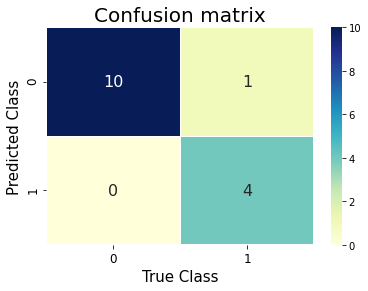

In [165]:
cm = confusion_matrix(y_validation, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title("Confusion matrix", size = 20)

Sarebbe interessante tenere una feature che senta il numero di silenzi

## Spectrogram

Proviamo a fare degli spettrogrammi. Per farlo dobbiamo reimportare nuovamente i dati ma senza aggiungere feature

In [166]:
X_train, X_validation, y_train, y_validation = load_data()

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


In [171]:
spect = librosa.feature.melspectrogram(y=X_train[2], n_mels=128)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

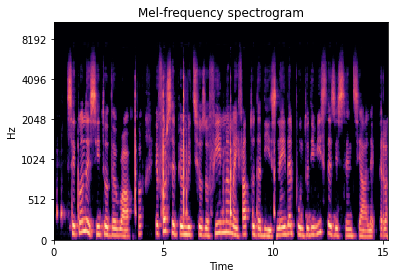

In [172]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spect, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
#plt.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [182]:
def create_spect():
  for f in sorted(os.listdir(base_dir)):
    if f.endswith('.mp3'):
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None) 
            print(f)
            name = re.search(r'^(\d+)_([01])\.mp3$', f).group(1)
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            S_dB = librosa.power_to_db(spect, ref=np.max)
            img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
            if label == 0:
              plt.savefig(base_dir + "spectrograms/letto/{}_{}.png".format(name, label), dpi = 100)
            elif label == 1:
              plt.savefig(base_dir + "spectrograms/improvvisato/{}_{}.png".format(name, label), dpi = 100)
            plt.close("all")

In [183]:
create_spect()

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


# KERAS

importiamo ora i file con il generator di keras